# Modèle ColBERT

On s'intéresse ici au modèle ColBERT, qui propose ...

In [1]:
!pip install --upgrade python-terrier
!pip install --upgrade git+https://github.com/terrierteam/pyterrier_colbert


     |████████████████████████████████| 92kB 6.4MB/s 
     |████████████████████████████████| 1.1MB 42.9MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 215kB 55.1MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 6.3MB 42.6MB/s 
     |████████████████████████████████| 1.8MB 36.9MB/s 
     |████████████████████████████████| 81kB 12.9MB/s 
     |████████████████████████████████| 645kB 39.5MB/s 
     |████████████████████████████████| 133kB 59.2MB/s 
     |████████████████████████████████| 296kB 52.2MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.6.0-cp37-none-any.whl size=93214 sha256=5588dd2169d3abec8a802315d7ea6645d1df40a6839f7e4ce4251244cd3b6444
  Stored in directory: /root/.cache/pip/wheels/9f/8d/91/58da79fd0a2850843b7e8c6097a52f9ff7aa85953cc9c8d27f
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=a127596becc8790423eee3d36ca516e48abbe

In [2]:
#initialisation pyterrier
import pyterrier as pt
if not pt.started():
    pt.init()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


terrier-assemblies 5.5  jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.5  jar not found, downloading to /root/.pyterrier...
Done
PyTerrier 0.6.0 has loaded Terrier 5.5 (built by craigmacdonald on 2021-05-20 13:12)


In [3]:
#récupération du dataset covid19
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
topics = dataset.get_topics(variant='description')
qrels = dataset.get_qrels()

#construction de l'index
import os

cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = './terrier_cord19'

if not os.path.exists(pt_index_path + "/data.properties"):
    # create the index, using the IterDictIndexer indexer 
    indexer = pt.index.IterDictIndexer(pt_index_path)

    # we give the dataset get_corpus_iter() directly to the indexer
    # while specifying the fields to index and the metadata to record
    index_ref = indexer.index(cord19.get_corpus_iter(), 
                              fields=('abstract',), 
                              meta=('docno',))

else:
    # if you already have the index, use it.
    index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")

index = pt.IndexFactory.of(index_ref)


import os

if not os.path.exists("terrier_index.zip"):
  !wget http://www.dcs.gla.ac.uk/~craigm/ecir2021-tutorial/terrier_index.zip
  !unzip -j terrier_index.zip -d terrier_index

index_ref = pt.IndexRef.of("./terrier_index/data.properties")
index = pt.IndexFactory.of(index_ref)

[INFO] If you have a local copy of https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/0307a37b6b9f1a5f233340a769d538ea
[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [484kB/s]
[INFO] If you have a local copy of https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/8138424a59daea0aba751c8a891e5f54
[INFO] [starting] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt: [00:05] [1.14MB] [193kB/s]
[INFO] If you have a local copy of https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/80d664e496b

13:20:01.495 [ForkJoinPool-1-worker-3] WARN  o.t.structures.indexing.Indexer - Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed

13:21:02.320 [ForkJoinPool-1-worker-3] WARN  o.t.structures.indexing.Indexer - Indexed 54937 empty documents
--2021-06-17 13:21:08--  http://www.dcs.gla.ac.uk/~craigm/ecir2021-tutorial/terrier_index.zip
Resolving www.dcs.gla.ac.uk (www.dcs.gla.ac.uk)... 130.209.240.1
Connecting to www.dcs.gla.ac.uk (www.dcs.gla.ac.uk)|130.209.240.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42017186 (40M) [application/zip]
Saving to: ‘terrier_index.zip’

terrier_index.zip   100%[===================>]  40.07M  13.1MB/s    in 3.1s    

2021-06-17 13:21:11 (13.1 MB/s) - ‘terrier_index.zip’ saved [42017186/42017186]

Archive:  terrier_index.zip
  inflating: terrier_index/data.lexicon.fsomapfile  
  inflating: terrier_index/data.properties  
  inflating: terrier_index/data.lexicon.fsomaphash  
  inflating: terrier_ind

## chargement du modèle ColBERT

In [4]:
import pyterrier_colbert.ranking
colbert_factory = pyterrier_colbert.ranking.ColBERTFactory(
    "http://www.dcs.gla.ac.uk/~craigm/colbert.dnn.zip", None, None)
colbert = colbert_factory.text_scorer(doc_attr='abstract')

[INFO] PyTorch version 1.8.1+cu101 available.
[INFO] TensorFlow version 2.5.0 available.
/usr/local/lib/python3.7/dist-packages/pyterrier_colbert/ranking.py:221: UserWarning: No index_root and index_name specified - no index ranking possible
  warn("No index_root and index_name specified - no index ranking possible")
/usr/local/lib/python3.7/dist-packages/pyterrier_colbert/ranking.py:237: UserWarning: Faiss not installed. You cannot do retrieval
  warn("Faiss not installed. You cannot do retrieval")
[INFO] Lock 139884891868112 acquired on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock
[INFO] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpcmarjxis


[INFO] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json in cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
[INFO] creating metadata file for /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
[INFO] Lock 139884891868112 released on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock
[INFO] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
[INFO] Model config BertConfig {
 

[INFO] storing https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin in cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
[INFO] creating metadata file for /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
[INFO] Lock 139884892014864 released on /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157.lock
[INFO] loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
[WARNING] Some weights of the model checkpoint at bert-base-uncased were not u

[Jun 17, 13:21:42] #> Loading model checkpoint.
[Jun 17, 13:21:42] #> Loading checkpoint http://www.dcs.gla.ac.uk/~craigm/colbert.dnn.zip


Downloading: "http://www.dcs.gla.ac.uk/~craigm/colbert.dnn.zip" to /root/.cache/torch/hub/checkpoints/colbert.dnn.zip


/usr/local/lib/python3.7/dist-packages/torch/hub.py:452: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


[Jun 17, 13:22:53] #> checkpoint['epoch'] = 0
[Jun 17, 13:22:53] #> checkpoint['batch'] = 44500


[INFO] Lock 139884891168464 acquired on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
[INFO] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmppnh1o9hy


[INFO] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt in cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
[INFO] creating metadata file for /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
[INFO] Lock 139884891168464 released on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
[INFO] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
[INFO] loading file https://s3.amazonaws.com/models.

Exécution des requêtes du dataset et calcul des métriques

In [5]:
br = pt.BatchRetrieve(index) % 100
pipeline = br >> pt.text.get_text(dataset, 'abstract') >> colbert
pt.Experiment(
    [br, pipeline],
    topics,
    qrels,
    names=['DPH', 'DPH >> ColBERT'],
    eval_metrics=["map", "ndcg", 'ndcg_cut.10', 'P.10', 'mrt']
)

[INFO] NumExpr defaulting to 2 threads.


,name,map,ndcg,ndcg_cut.10,P.10,mrt
0,DPH,0.068006,0.165607,0.609058,0.658,70.608992
1,DPH >> ColBERT,0.074670,0.172034,0.690447,0.752,530.858721


on souhaite ici visualiser les résultats du modèle, et surtout visualiser l'attention calculée sur le texte.

In [6]:
res = pipeline(topics.iloc[:1])
res.merge(dataset.get_qrels(), how='left').head()

,qid,query,docno,score,rank,label,iteration
0,1,what is the origin of covid 19,4dtk1kyh,24.866121,0,2.0,3
1,1,what is the origin of covid 19,jwxt4ygt,23.811007,1,2.0,3.5
2,1,what is the origin of covid 19,bn7hsuv9,23.811007,2,2.0,3.5
3,1,what is the origin of covid 19,6ck2ntid,23.699537,3,NaN,NaN
4,1,what is the origin of covid 19,8a6flxl6,23.699537,4,NaN,NaN


le premier document est pertinent pour la requête q0. Nous observons ci-dessous la carte d'attention associée au calcul du score : 

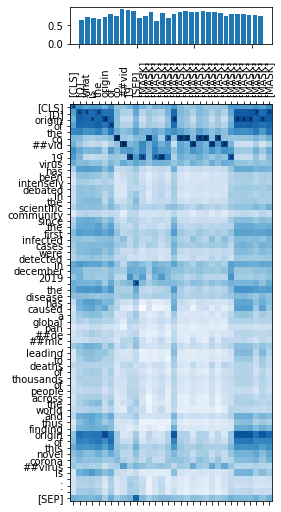

In [7]:
text = dataset.irds_ref().docs_store().get('4dtk1kyh').abstract[:300] + '...' # truncate text
colbert_factory.explain_text('what is the origin of covid 19', text)